In [1]:
import patsy as pa
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions

from MakeMyPrior.elicitation_wrapper import expert_model
from MakeMyPrior.training import trainer
from MakeMyPrior.helper_functions import group_obs, Exponential_unconstrained, Normal_unconstrained
from MakeMyPrior.user_config import target_config, target_input
from MakeMyPrior.discrepancy_measures import energy_loss
from MakeMyPrior.helper_functions import print_restab, plot_priors_hyp, plot_expert_preds, group_stats, plot_priors_flow
import MakeMyPrior.combine_losses 

from tabulate import tabulate
import pprint
pp = pprint.PrettyPrinter(depth=4)

tf.random.set_seed(2024)

C:\Users\flobo\anaconda3\envs\make-my-prior\Lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Case Study: Normal model

\begin{align*}
    y_i &\sim \text{Normal}(\theta_i, s)\\
    \theta_i &= \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4 + \beta_5x_5\\
    \beta_k &\sim \text{Normal}(\mu_k, \sigma_k) \quad \text{for }k=0,\ldots, 5\\
    s &\sim \text{Exponential}(\nu)
\end{align*}

## User specification

### Setting hyperparameter for the learning algorithm

In [2]:
# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**8,                          
        rep = 200,                         
        epochs = 400,                      
        view_ep = 20,
        lr_decay = True,
        lr0 = 0.001, 
        lr_min = 0.000001, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = [energy_loss()]*11,       
        loss_scaling = "unscaled",         
        method = "normalizing_flow"  
        )

### Define the design matrix

In [3]:
# construct design matrix
X =  pa.dmatrix("a*b", pa.balanced(a = 2, b = 3, repeat = 60), return_type="dataframe")
dmatrix = tf.cast(X, dtype = tf.float32)
# extract contrast matrix from design matrix (for allocating observations to groups)
cmatrix = dmatrix[0:dmatrix.shape[1], :]

print(X)

     Intercept  a[T.a2]  b[T.b2]  b[T.b3]  a[T.a2]:b[T.b2]  a[T.a2]:b[T.b3]
0          1.0      0.0      0.0      0.0              0.0              0.0
1          1.0      0.0      1.0      0.0              0.0              0.0
2          1.0      0.0      0.0      1.0              0.0              0.0
3          1.0      1.0      0.0      0.0              0.0              0.0
4          1.0      1.0      1.0      0.0              1.0              0.0
..         ...      ...      ...      ...              ...              ...
355        1.0      0.0      1.0      0.0              0.0              0.0
356        1.0      0.0      0.0      1.0              0.0              0.0
357        1.0      1.0      0.0      0.0              0.0              0.0
358        1.0      1.0      1.0      0.0              1.0              0.0
359        1.0      1.0      0.0      1.0              0.0              1.0

[360 rows x 6 columns]


### Setup the 'ideal agent'
Define an 'arbitrary' ground truth for the hyperparameter values for method validation.

1. Define *true* hyperparameter values (for method validation; check recovery)
2. Specify for each model parameter:
    + `family`: prior distribution family
    + `initialization`: initial hyperparameter value as starting point for the learning algorithm
    + `true`: prior distributions with true hyperparameter values as defined in 1.)

In [4]:
# true hyperparameter values for ideal_expert
true_values = dict()
true_values["mu"] = [0.12, 0.15, -0.02, -0.03, -0.02, -0.04]
true_values["sigma"] = [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]
true_values["nu"] = 9.

# model parameters
parameters_dict = dict()
for i in range(6):
    parameters_dict[f"beta_{i}"] = {
            "true": tfd.Normal(true_values["mu"][i], true_values["sigma"][i]),
            "initialization": [tfd.Normal(0.,0.1)]*2
            }

parameters_dict["sigma"] = {
        "true": tfd.Exponential(true_values["nu"]),
        #"true": tfd.ExpGamma(user_config["rep"], user_config["rep"]*true_values["nu"]),
        "initialization": [tfd.Normal(0.,0.1)]
        }

print("True hyperparameter values:")
pp.pprint(true_values)
print("")
print("Specify prior distribution per model parameter:")
pp.pprint(parameters_dict)

True hyperparameter values:
{'mu': [0.12, 0.15, -0.02, -0.03, -0.02, -0.04],
 'nu': 9.0,
 'sigma': [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]}

Specify prior distribution per model parameter:
{'beta_0': {'initialization': [<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
                               <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>],
            'true': <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>},
 'beta_1': {'initialization': [<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
                               <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>],
            'true': <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>},
 'beta_2': {'initialization': [<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
                               <tfp.distribution

### Define the data generating model

In [5]:
# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters, # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,    # optional: design matrix; tf.Tensor
                 cmatrix,    # optional: contrast matrix; tf.Tensor
                 **kwargs    # obligatory: possibility for further keyword arguments is needed 
                 ):  

        # transformed sigma parameter
        sigma_avg = tf.math.reduce_mean(tf.exp(parameters[:,:,-1]), axis = 1)[:,None,None]
        
        # compute linear predictor term
        epred = parameters[:,:,0:6] @ tf.transpose(dmatrix)
        
        # define likelihood
        likelihood = tfd.Normal(
            loc = epred, 
            scale = tf.broadcast_to(sigma_avg, shape = epred.shape)
        )
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # compute custom target quantity (here: group-differences)
        samples_grouped = group_obs(ypred, dmatrix, cmatrix)

        # compute mean difference between groups
        effect_list = []
        diffs = [(3,0), (4,1), (5,2)]
        for i in range(len(diffs)):
            # compute group difference
            diff = tf.math.subtract(
                samples_grouped[:, :, :, diffs[i][0]],
                samples_grouped[:, :, :, diffs[i][1]]
            )
            # average over individual obs within each group
            diff_mean = tf.reduce_mean(diff, axis=2)
            # collect all mean group differences
            effect_list.append(diff_mean)

        mean_effects = tf.stack(effect_list, axis=-1)

        factor_marginals = tf.reduce_sum([samples_grouped[:, :, :, 0]] for i in range(3)])
        
        return dict(likelihood = likelihood,      # obligatory: likelihood; callable
                    ypred = ypred,                # obligatory: prior predictive data
                    epred = epred,                # obligatory: samples from linear predictor
                    mean_effects = mean_effects,   # optional: custom target quantity
                    sigma = tf.exp(parameters[:,:,-1])
                    )

### Specify the target quantities and the elicitation technique

In [6]:
 # define a custom function using the output from the generative model   
def custom_r2(ypred, epred, **kwargs):
    return tf.math.divide(tf.math.reduce_variance(epred, axis = -1), 
                          tf.math.reduce_variance(ypred, axis = -1))

# specify target quantity, elicitation technique and loss combination
t1 = target_config(target="R2", 
                   elicitation="histogram",
                   combine_loss="all",
                   custom_target_function = custom_r2)
t2 = target_config(target="group_means", 
                   elicitation="quantiles", 
                   combine_loss="by-group", 
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t3 = target_config(target="mean_effects", 
                   elicitation="quantiles",
                   combine_loss="by-group",
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t4 = target_config(target="sigma", 
                   elicitation="histogram",
                   combine_loss="all")
target_info = target_input(t1, t2, t3)

pp.pprint(target_info)

{'combine_loss': ['all', 'by-group', 'by-group'],
 'custom_target_function': [<function custom_r2 at 0x0000029512CBD3A0>,
                            None,
                            None],
 'elicitation': ['histogram', 'quantiles', 'quantiles'],
 'internal_loss': [None, None, None],
 'quantiles_specs': [(10, 20, 30, 40, 50, 60, 70, 80, 90),
                     (10, 20, 30, 40, 50, 60, 70, 80, 90)],
 'target': ['R2', 'group_means', 'mean_effects']}


## Expert model

In [7]:
expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                   parameters_dict, GenerativeModel, target_info,
                                   method = "ideal_expert_nf",
                                   dmatrix = dmatrix,
                                   cmatrix = cmatrix,
                                   dmatrix_fct = dmatrix)

# elicited statistics from the (ideal) expert
expert_res_list.keys()

transform applied


dict_keys(['R2_hist_0', 'group_means_quant_1', 'mean_effects_quant_2'])

### Expert predictions

<Axes: ylabel='Density'>

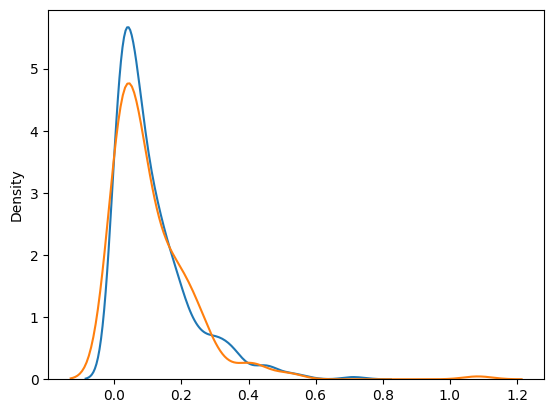

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

_, axes = plt.subplots(1,1)
sns.kdeplot(tfd.Exponential(9.).sample(1000), ax = axes )
sns.kdeplot(tf.exp(prior_pred_res["priors"][0,:,-1]), ax = axes )

In [9]:
# group means
print(group_stats(prior_pred_res["ypred"], num_groups = 6))
# mean effects
print("mean effects:")
print(np.round(tf.reduce_mean(prior_pred_res["mean_effects"],(0,1)),2))

+-------+------+------+
| group | mean | std  |
+-------+------+------+
|  gr_0 | 0.12 | 0.02 |
|  gr_1 | 0.1  | 0.06 |
|  gr_2 | 0.09 | 0.07 |
|  gr_3 | 0.27 | 0.03 |
|  gr_4 | 0.22 | 0.07 |
|  gr_5 | 0.2  | 0.08 |
+-------+------+------+
mean effects:
[0.15 0.13 0.11]


C:\Users\flobo\MakeMyPrior\MakeMyPrior\helper_functions.py:417: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(["r","new: deep","new: standard","new: shallow","rep: deep","rep: standard","rep: shallow"])


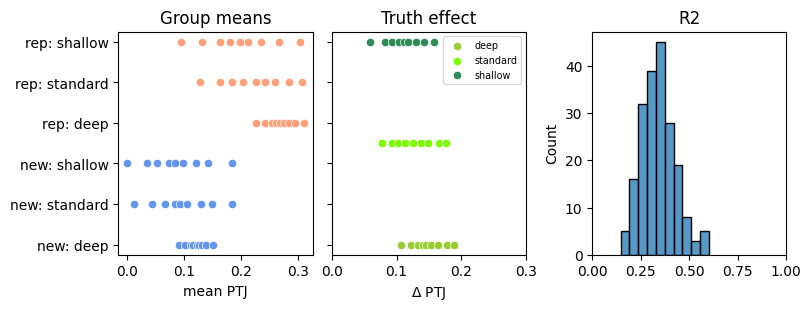

In [10]:
# plot expert predictions
plot_expert_preds(expert_res_list)

## Learning Algorithm

In [11]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info, user_config, loss_balancing = True, save_vals = ["prior_preds"],
                   dmatrix = dmatrix, cmatrix = cmatrix, dmatrix_fct = dmatrix)

epoch_time: 1122.566ms
Epoch: 0, loss: 0.76833, lr: 0.001000
epoch_time: 238.645ms
Epoch: 20, loss: 0.14646, lr: 0.000656
epoch_time: 262.711ms
Epoch: 40, loss: 0.02217, lr: 0.000430
epoch_time: 251.316ms
Epoch: 60, loss: 0.01407, lr: 0.000282
epoch_time: 242.514ms
Epoch: 80, loss: 0.01111, lr: 0.000185
epoch_time: 234.649ms
Epoch: 100, loss: 0.00942, lr: 0.000122
epoch_time: 239.327ms
Epoch: 120, loss: 0.00876, lr: 0.000080
epoch_time: 261.451ms
Epoch: 140, loss: 0.00908, lr: 0.000052
epoch_time: 246.332ms
Epoch: 160, loss: 0.00866, lr: 0.000034
epoch_time: 242.862ms
Epoch: 180, loss: 0.00822, lr: 0.000023
epoch_time: 256.226ms
Epoch: 200, loss: 0.00841, lr: 0.000015
epoch_time: 236.782ms
Epoch: 220, loss: 0.00845, lr: 0.000010
epoch_time: 244.949ms
Epoch: 240, loss: 0.00884, lr: 0.000006
epoch_time: 247.724ms
Epoch: 260, loss: 0.00832, lr: 0.000004
epoch_time: 231.246ms
Epoch: 280, loss: 0.00840, lr: 0.000003
epoch_time: 264.756ms
Epoch: 300, loss: 0.00912, lr: 0.000002
epoch_time: 2

### Training results

#### Loss

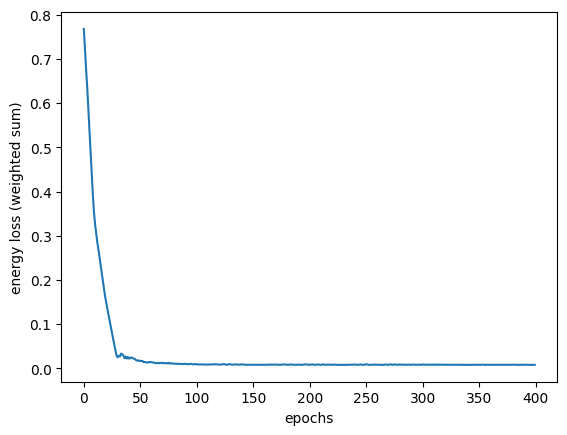

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(res_dict["loss_info"])), res_dict["loss_info"]) 
plt.xlabel("epochs")
plt.ylabel("energy loss (weighted sum)")
plt.show()

#### Learned hyperparameter values

In [13]:
sig = tf.expand_dims(tf.exp(res_dict["priors_info"][0]["priors"][:,:,-1]),-1)
prior_samples = tf.concat([res_dict["priors_info"][0]["priors"][:,:,0:6], sig],-1)

In [14]:
print_restab(method = "normalizing_flow", res = prior_samples,
             precision = 2, true_mu = true_values["mu"], true_sigma = true_values["sigma"], 
             true_nu = true_values["nu"], names = [f"beta{i}" for i in range(6)]+["sigma"])

var_name,pred mean,pred std,true mean,err mean,true std,err std
beta0,0.12,0.02,0.12,0.0,0.02,0.0
beta1,0.15,0.03,0.15,0.0,0.02,0.01
beta2,-0.03,0.06,-0.02,0.01,0.06,0.0
beta3,-0.03,0.08,-0.03,0.0,0.06,0.02
beta4,-0.02,0.05,-0.02,0.0,0.03,0.02
beta5,-0.04,0.05,-0.04,0.0,0.03,0.02
sigma,0.11,0.06,0.11,0.0,0.11,0.05


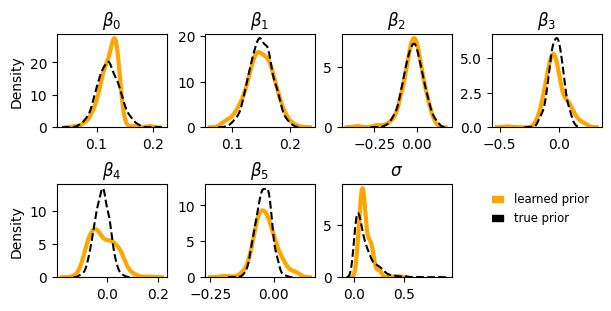

In [15]:
plot_priors_flow(prior_samples, true_values["mu"], true_values["sigma"], true_values["nu"])

<Axes: ylabel='Density'>

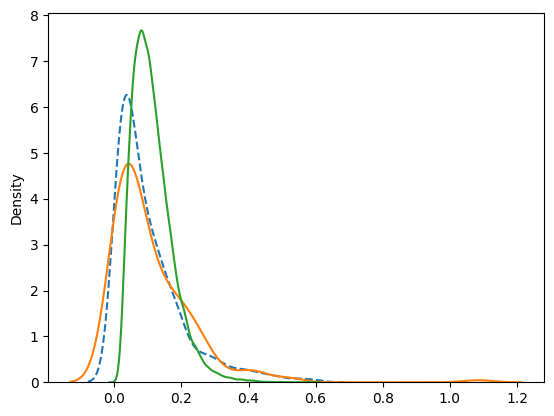

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

_, axes = plt.subplots(1,1)
sns.kdeplot(tfd.Exponential(9.).sample(1000), ax = axes, linestyle = "dashed")
sns.kdeplot(tf.exp(prior_pred_res["priors"][0,:,-1]), ax = axes )
#sns.kdeplot(tfd.Gamma(user_config["rep"], user_config["rep"]*9.).sample(1000), ax = axes, linestyle = "dashed")
sns.kdeplot(tf.reshape(tf.exp(res_dict["priors_info"][0]["priors"][:,:,-1]), [user_config["rep"]*user_config["B"]]))